In [9]:
import os
import time
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import MultiTaskElasticNetCV
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import json

# INGRESO DE DATOS

In [36]:
# Cargar y ordenar las tablas por orden alfabetico para comaprar correctamente las predicciones
Ypd = pd.read_csv("data/THYR_EDA.csv", index_col=0).sort_index(axis=0)
Xpd = pd.read_csv("data/BLOOD_EDA_filtrado.csv", index_col=0).sort_index(axis=0)

# CONVERSION DE DATOS

In [37]:
# Guardar nombres antes de convertir
genes = Xpd.columns.tolist()  
vias = Ypd.columns.tolist()     
samples = Xpd.index.tolist()    

# Convertir a NumPy arrays
X = Xpd.values  # o Xpd.to_numpy()
Y = Ypd.values  # o Ypd.to_numpy()

# CONFIGURACION DE VARIABLES

In [13]:
# CV externa: para evaluar el rendimiento general del modelo
cv_exter = KFold(n_splits=5, shuffle=True, random_state=42)

# CV interna: usada por MultiTaskElasticNetCV
cv_inter = KFold(n_splits=5, shuffle=True, random_state=42)

# Parámetros para MultiTaskElasticNetCV
l1_ratios = [0.1, 0.5, 0.95]  # Proporción de penalización L1
alphas = np.logspace(-3, 3, 20)

# Resultados
metricas_externas = [] #outer_scores
mejores_parametros = [] # best_params_per_fold
mejores_rutas = [] # feature_importance_per_fold

# Carpetas

if not os.path.exists("CVAnidada/data"):
    os.makedirs("CVAnidada/data")
if not os.path.exists("CVAnidada/graph"):
    os.makedirs("CVAnidada/graph")

# CV EXTERNA

In [20]:
fold = 1
metricas = {}
for (train_id, test_id) in cv_exter.split(X):
    print(f"\nFOLD EXTERNO {fold}/5")
    fold += 1  

    # Dividir datos
    X_train, X_test = X[train_id], X[test_id]
    Y_train, Y_test = Y[train_id], Y[test_id]

    # Modelo con CV interna
    modelo = MultiTaskElasticNetCV(
        l1_ratio = l1_ratios,
        alphas = alphas,
        cv = cv_inter,
        n_jobs = 4,
        max_iter = 2000,
        selection = 'random',
        random_state =42
    )
    
     # Entrenar modelo (ejecuto entrenamiento CV interna)
    print(f"\n\tEntrenando con CV interna ({cv_inter.n_splits} folds)...")
    modelo.fit(X_train, Y_train)
    
    # Mejores métrica
    mejor_alpha = modelo.alpha_
    mejor_l1 = modelo.l1_ratio_
    print(f"\tMejor alpah:{mejor_alpha:.4f}")
    print(f"\tMejor l1_ratio:{mejor_l1:.4f}")
    
    # Predicción en muestras test
    Y_pred = modelo.predict(X_test)
    
    # Calcular métricas para cada tarea
    fold_metricas = {}
    print(f"\tEvaluación test/predición:")
    for via_idx in range(Y.shape[1]):
        via = vias[via_idx]
        
        mse = mean_squared_error(Y_test[:, via_idx], Y_pred[:, via_idx])
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(Y_test[:, via_idx], Y_pred[:, via_idx])
        r2 = r2_score(Y_test[:, via_idx], Y_pred[:, via_idx])

        # Guardar resultados de metricas por ruta
        fold_metricas[f'via_{via}_rmse'] = rmse
        fold_metricas[f'via_{via}_mae'] = mae
        fold_metricas[f'via_{via}_r2'] = r2
        
    # Guardar resultados
    fold_metricas['mejor_alpha'] = mejor_alpha
    fold_metricas['mejor_l1_ratio'] = mejor_l1
    metricas_externas.append(fold_metricas)
    mejores_parametros.append({'alpha': mejor_alpha, 'l1_ratio': mejor_l1})
    mejores_rutas.append(np.abs(modelo.coef_))

    metricas[fold] = fold_metricas
    print(f"\nFIN FOLD EXTERNO {fold}")
    


FOLD EXTERNO 1/5

	Entrenando con CV interna (5 folds)...

	Mejor alpah:6.1585

	EMejor l1_ratio:0.1000
	Evaluación test/predición:

FIN FOLD EXTERNO 2

FOLD EXTERNO 2/5

	Entrenando con CV interna (5 folds)...

	Mejor alpah:6.1585

	EMejor l1_ratio:0.1000
	Evaluación test/predición:

FIN FOLD EXTERNO 3

FOLD EXTERNO 3/5

	Entrenando con CV interna (5 folds)...

	Mejor alpah:6.1585

	EMejor l1_ratio:0.1000
	Evaluación test/predición:

FIN FOLD EXTERNO 4

FOLD EXTERNO 4/5

	Entrenando con CV interna (5 folds)...

	Mejor alpah:6.1585

	EMejor l1_ratio:0.1000
	Evaluación test/predición:

FIN FOLD EXTERNO 5

FOLD EXTERNO 5/5

	Entrenando con CV interna (5 folds)...

	Mejor alpah:6.1585

	EMejor l1_ratio:0.1000
	Evaluación test/predición:

FIN FOLD EXTERNO 6


# GENERACIÓN DE ARCHIVOS CON RESULTADOS

In [48]:
# Guardar métricas externas
with open("CVAnidada/data/metricas_externas.json", "w") as f:
    json.dump(metricas_externas, f, indent=4)


In [3]:
# Guardar coeficientes
mejores_rutas_limpio = [arr.tolist() for arr in mejores_rutas]
with open("CVAnidada/data/mejores_rutas.json", "w") as f:
    json.dump(mejores_rutas_limpio, f, indent=4)

NameError: name 'mejores_rutas' is not defined

In [97]:
# Guardar Promedios de Resultados
df_resultados = pd.DataFrame(metricas_externas)
pd.DataFrame(df_resultados).to_csv('CVAnidada/data/resultados.csv', index=False, float_format='%.4f')

# CARGA RESULTADOS

In [12]:
with open("CVAnidada/data/metricas_externas.json", "r") as f:
    metricas_externas = json.load(f)
with open("CVAnidada/data/mejores_rutas.json", "r") as f:
    mejores_rutas = json.load(f)

In [15]:
pd_resultados = pd.read_csv("CVAnidada/data/resultados.csv", index_col=0).sort_index(axis=0)

# ANÁLISIS DE RESULTADOS

In [61]:
print("RESUMEN DE RESULTADOS")

print("\n MÉTRICAS PROMEDIO ENTRE LOS FOLDS:")

rmse_resultados = []
mae_resultados = []
r2_resultados = []

for via_idx in range(Y.shape[1]): 
    via = vias[via_idx]
    
    rmse_mean = df_resultados[f'via_{via}_rmse'].mean()
    rmse_std = df_resultados[f'via_{via}_rmse'].std()
    mae_mean = df_resultados[f'via_{via}_mae'].mean()
    mae_std = df_resultados[f'via_{via}_mae'].std()
    r2_mean = df_resultados[f'via_{via}_r2'].mean()
    r2_std = df_resultados[f'via_{via}_r2'].std()

    rmse_resultados.append({
        'Task_Name': via,
        'Mean': rmse_mean,
        'Std': rmse_std
    })
    
    mae_resultados.append({
        'Task_Name': via,
        'Mean': mae_mean,
        'Std': mae_std
    })
    
    r2_resultados.append({
        'Task_Name': via,
        'Mean': r2_mean,
        'Std': r2_std
    })

# Guardar cada métrica en su propio archivo
pd.DataFrame(rmse_resultados).to_csv('CVAnidada/data/resultados_RMSE.csv', index=False, float_format='%.4f')
pd.DataFrame(mae_resultados).to_csv('CVAnidada/data/resultados_MAE.csv', index=False, float_format='%.4f')
pd.DataFrame(r2_resultados).to_csv('CVAnidada/data/resultados_R2.csv', index=False, float_format='%.4f')

print("\n\t ALPHAS Y L1_RATIO SELECCIONADOS POR FOLD:")

for i, parametros in enumerate(mejores_parametros, 1):
    print(f"  Fold {i}: alpha={parametros['alpha']:.6f}, l1_ratio={parametros['l1_ratio']:.3f}")

alpha_mean = df_resultados['mejor_alpha'].mean()
alpha_std = df_resultados['mejor_alpha'].std()
l1_ratio_mean = df_resultados['mejor_l1_ratio'].mean()
l1_ratio_std = df_resultados['mejor_l1_ratio'].std()

print(f"\n\tPromedio: \n\talpha={alpha_mean:.6f} ± {alpha_std:.6f}")
print(f"\n\tl1_ratio={l1_ratio_mean:.3f} ± {l1_ratio_std:.3f}")

RESUMEN DE RESULTADOS

 MÉTRICAS PROMEDIO ENTRE LOS FOLDS:

	 ALPHAS Y L1_RATIO SELECCIONADOS POR FOLD:
  Fold 1: alpha=6.158482, l1_ratio=0.100
  Fold 2: alpha=6.158482, l1_ratio=0.100
  Fold 3: alpha=6.158482, l1_ratio=0.100
  Fold 4: alpha=6.158482, l1_ratio=0.100
  Fold 5: alpha=6.158482, l1_ratio=0.100

	Promedio: 
	alpha=6.158482 ± 0.000000

	l1_ratio=0.100 ± 0.000


# GRÁFICOS

## Alphas y L1_ratio por Fold

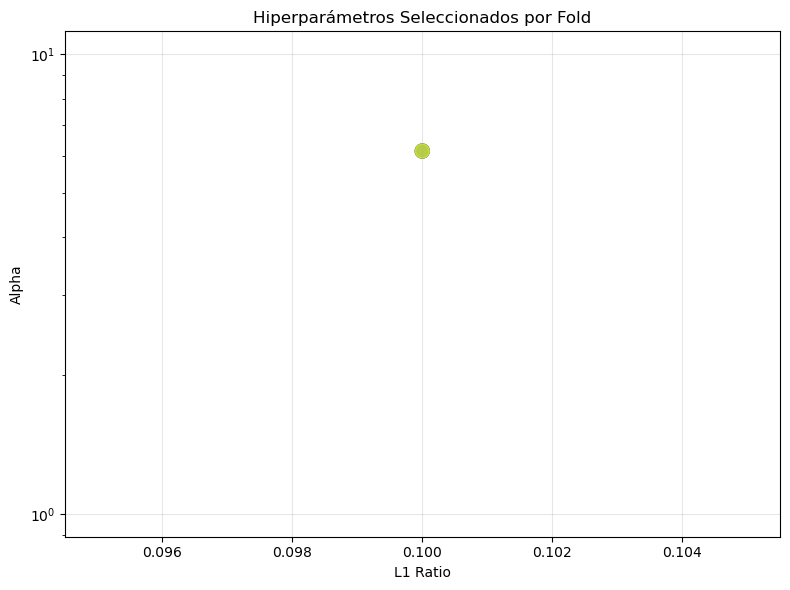

In [19]:
# Hiperparámetros seleccionados
fig, ax = plt.subplots(figsize=(8, 6))
#ax = axes[0, 1]
ax.scatter(df_resultados['mejor_l1_ratio'], df_resultados['mejor_alpha'], 
           s=100, alpha=0.6, c=range(len(df_resultados)), cmap='viridis')
ax.set_xlabel('L1 Ratio')
ax.set_ylabel('Alpha')
ax.set_yscale('log')
ax.set_title('Hiperparámetros Seleccionados por Fold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('CVAnidada/graph/alpha_ratio.png', dpi=300, bbox_inches='tight')
plt.show()

## Distribución de Métricas

### R2

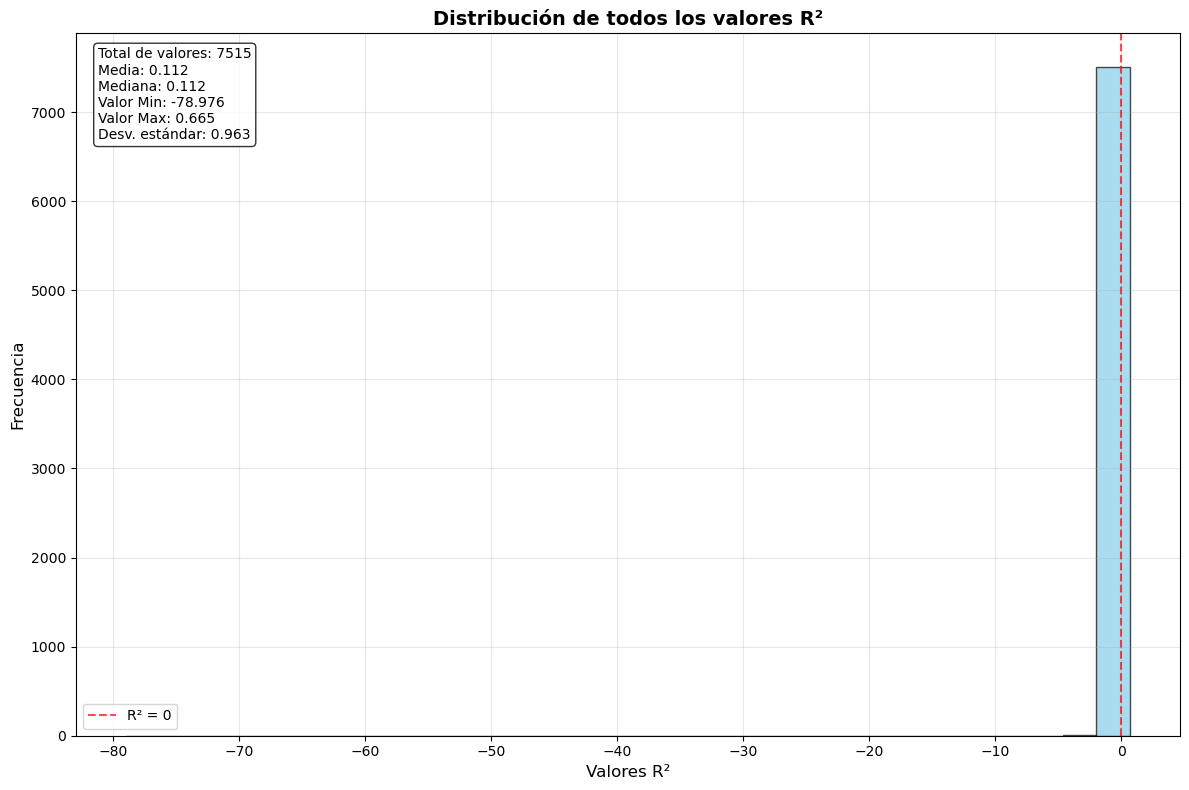

In [49]:
# Filtrar solo las columnas que terminan en '_r2'
columnas_r2 = [col for col in df_resultados.columns if col.endswith('_r2')]

# Crear el histograma
plt.figure(figsize=(12, 8))

# Combinar todos los valores R² en un solo array
todos_los_r2 = np.concatenate([df_resultados[col].values for col in columnas_r2])

# Crear el histograma
plt.hist(todos_los_r2, bins=30, alpha=0.7, color='skyblue', edgecolor='black')

# Personalizar el gráfico
plt.xlabel('Valores R²', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.title('Distribución de todos los valores R²', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Añadir línea vertical en R² = 0
plt.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='R² = 0')
plt.legend()

# Mostrar estadísticas descriptivas
plt.text(0.02, 0.98, f'Total de valores: {len(todos_los_r2)}\n'
                     f'Media: {np.mean(todos_los_r2):.3f}\n'
                     f'Mediana: {np.median(todos_los_r2):.3f}\n'
                     f'Valor Min: {np.min(todos_los_r2):.3f}\n'
                     f'Valor Max: {np.max(todos_los_r2):.3f}\n'
                     f'Desv. estándar: {np.std(todos_los_r2):.3f}',
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('CVAnidada/graph/mediasR2.png', dpi=300, bbox_inches='tight')
plt.show()

### RMSE

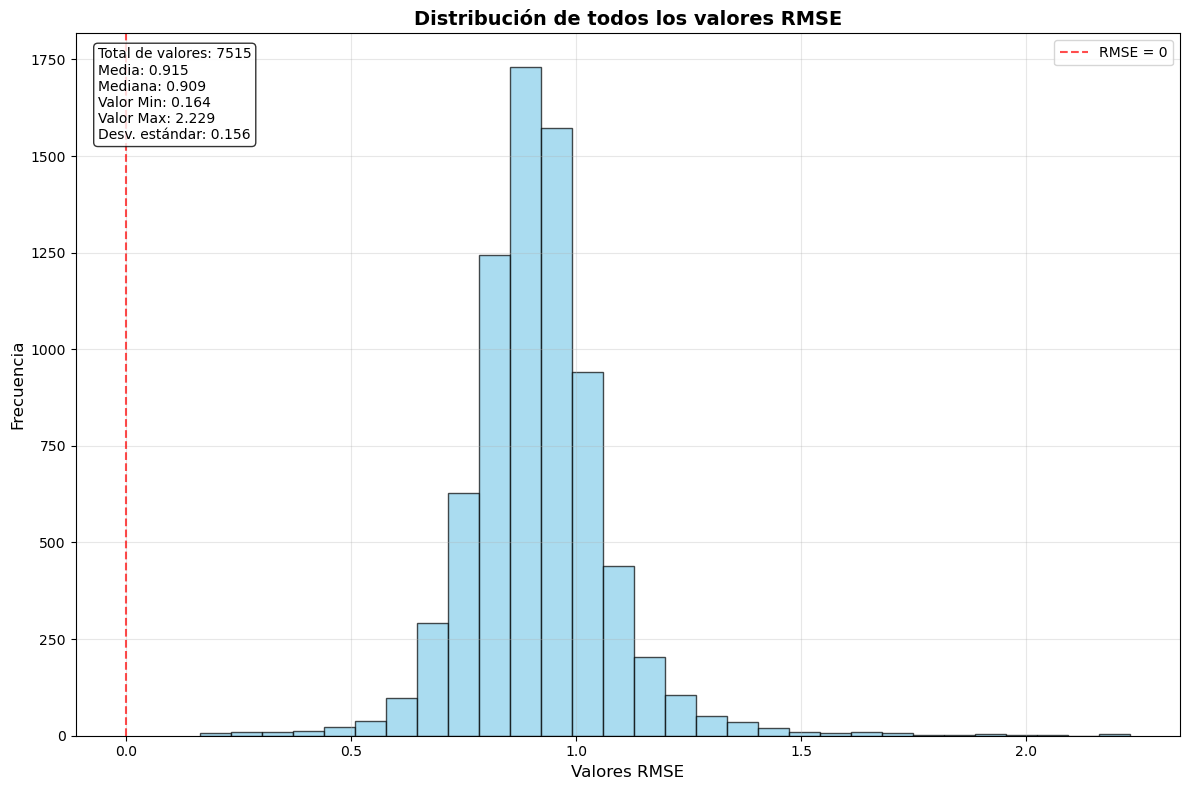

In [50]:
# Filtrar solo las columnas que terminan en '_rmse'
columnas_rmse = [col for col in df_resultados.columns if col.endswith('_rmse')]

# Crear el histograma
plt.figure(figsize=(12, 8))

# Combinar todos los valores R² en un solo array
todos_los_rmse = np.concatenate([df_resultados[col].values for col in columnas_rmse])

# Crear el histograma
plt.hist(todos_los_rmse, bins=30, alpha=0.7, color='skyblue', edgecolor='black')

# Personalizar el gráfico
plt.xlabel('Valores RMSE', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.title('Distribución de todos los valores RMSE', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Añadir línea vertical en RMSE = 0
plt.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='RMSE = 0')
plt.legend()

# Mostrar estadísticas descriptivas
plt.text(0.02, 0.98, f'Total de valores: {len(todos_los_rmse)}\n'
                     f'Media: {np.mean(todos_los_rmse):.3f}\n'
                     f'Mediana: {np.median(todos_los_rmse):.3f}\n'
                     f'Valor Min: {np.min(todos_los_rmse):.3f}\n'
                     f'Valor Max: {np.max(todos_los_rmse):.3f}\n'
                     f'Desv. estándar: {np.std(todos_los_rmse):.3f}',
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('CVAnidada/graph/mediasRMSE.png', dpi=300, bbox_inches='tight')
plt.show()

### MAE

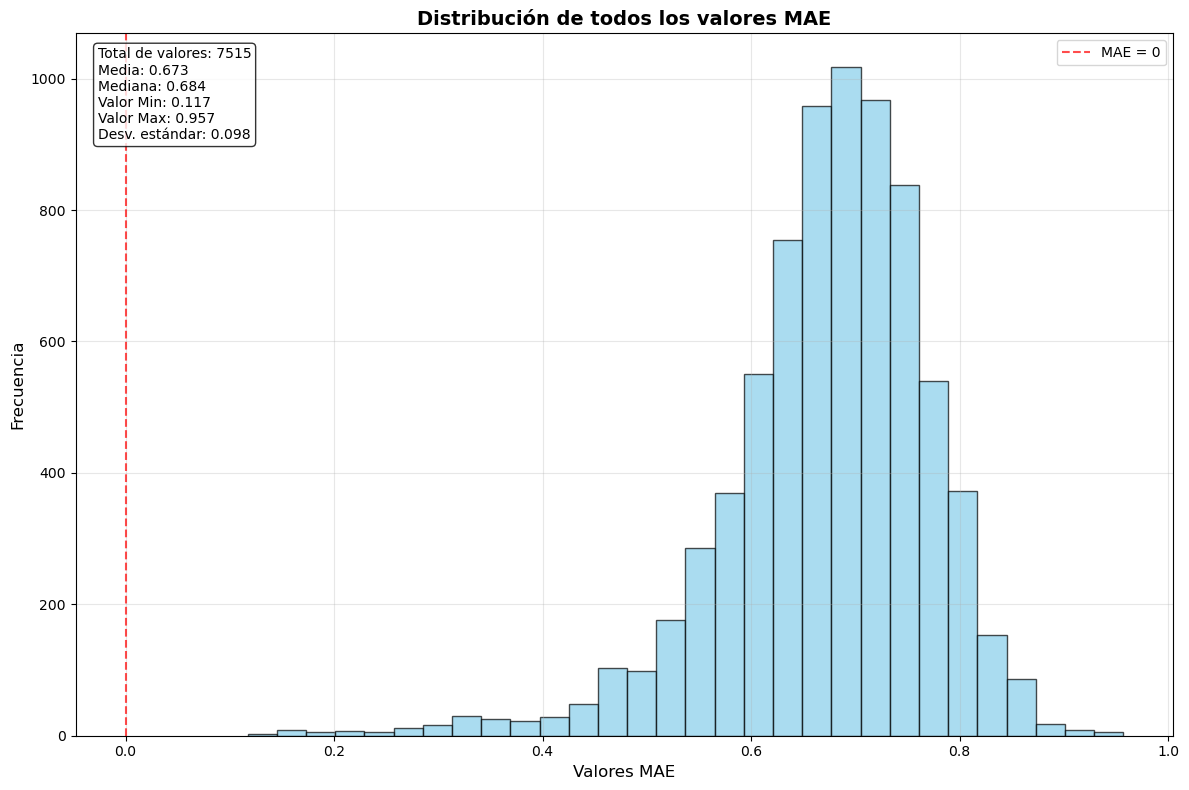

In [98]:
# Filtrar solo las columnas que terminan en '_mae'
columnas_mae = [col for col in df_resultados.columns if col.endswith('_mae')]

# Crear el histograma
plt.figure(figsize=(12, 8))

# Combinar todos los valores R² en un solo array
todos_los_mae = np.concatenate([df_resultados[col].values for col in columnas_mae])

# Crear el histograma
plt.hist(todos_los_mae, bins=30, alpha=0.7, color='skyblue', edgecolor='black')

# Personalizar el gráfico
plt.xlabel('Valores MAE', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.title('Distribución de todos los valores MAE', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Añadir línea vertical en RMSE = 0
plt.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='MAE = 0')
plt.legend()

# Mostrar estadísticas descriptivas
plt.text(0.02, 0.98, f'Total de valores: {len(todos_los_mae)}\n'
                     f'Media: {np.mean(todos_los_mae):.3f}\n'
                     f'Mediana: {np.median(todos_los_mae):.3f}\n'
                     f'Valor Min: {np.min(todos_los_mae):.3f}\n'
                     f'Valor Max: {np.max(todos_los_mae):.3f}\n'
                     f'Desv. estándar: {np.std(todos_los_mae):.3f}',
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('CVAnidada/graph/mae.png', dpi=300, bbox_inches='tight')
plt.show()

## Coeficientes

In [29]:
mejores_rutas = np.array(mejores_rutas)
print(f"Shape: {mejores_rutas.shape}")
print(f"- Dimensión 0 (modelos/iteraciones): {mejores_rutas.shape[0]}")
print(f"- Dimensión 1 (tareas/outputs): {mejores_rutas.shape[1]}")
print(f"- Dimensión 2 (genes/features): {mejores_rutas.shape[2]}")

Shape: (5, 1503, 3286)
- Dimensión 0 (modelos/iteraciones): 5
- Dimensión 1 (tareas/outputs): 1503
- Dimensión 2 (features): 3286


In [63]:
# Calcular estadísticas a través de las iteraciones
coef_mean = np.mean(mejores_rutas, axis=0)  # Media por tarea y feature
coef_std = np.std(mejores_rutas, axis=0)    # Desviación estándar
coef_cv = coef_std / (np.abs(coef_mean) + 1e-8)  # Coeficiente de variación

In [96]:
# Aunque sean no cero, pueden ser muy pequeños
coef_abs_mean = np.abs(coef_mean)
importancia_relativa = coef_abs_mean / np.max(coef_abs_mean)

# Ver cuántos coeficientes son realmente importantes
coef_importantes = np.sum(importancia_relativa > 0.01, axis=1)
print(f"Coeficientes con importancia > 1%: {np.mean(coef_importantes)/n_features:.3f}")

Coeficientes con importancia > 1%: 0.496


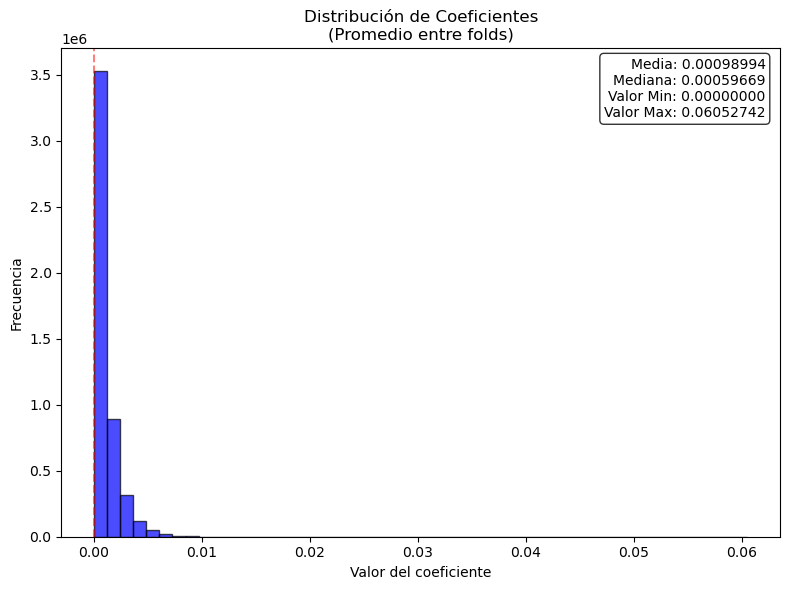

In [93]:
# Distribución de coeficientes promedio
plt.figure(figsize=(8, 6))
plt.hist(coef_mean.flatten(), bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.title('Distribución de Coeficientes\n(Promedio entre folds)')
plt.xlabel('Valor del coeficiente')
plt.ylabel('Frecuencia')
plt.axvline(x=0, color='red', linestyle='--', alpha=0.5)
plt.text(0.98, 0.98, f'Media: {np.mean(coef_mean):.8f}\n'
                     f'Mediana: {np.median(coef_mean):.8f}\n'
                     f'Valor Min: {np.min(coef_mean):.8f}\n'
                     f'Valor Max: {np.max(coef_mean):.8f}',
         transform=plt.gca().transAxes, verticalalignment='top',
         horizontalalignment='right' ,
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.tight_layout()
plt.savefig('CVAnidada/graph/coef.png', dpi=300, bbox_inches='tight')

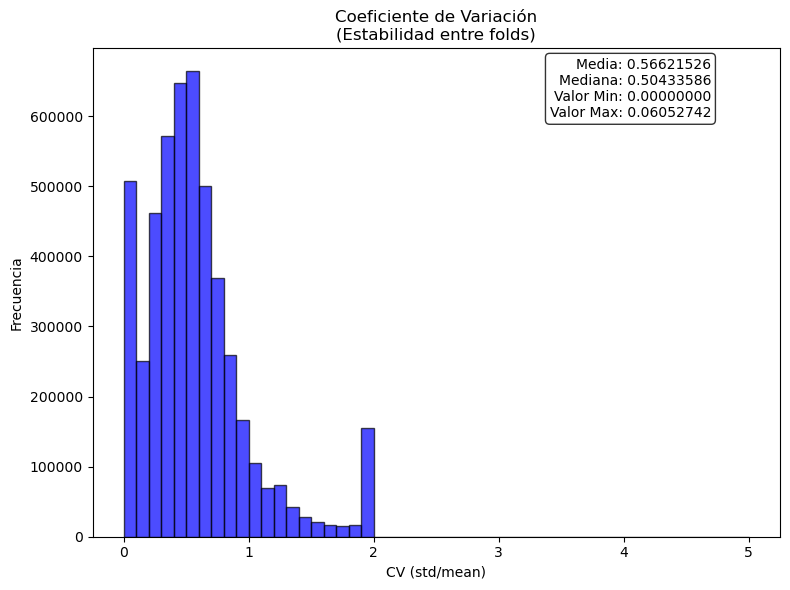

In [95]:
# Estabilidad de coeficientes (CV)
plt.figure(figsize=(8, 6))
plt.hist(coef_cv.flatten(), bins=50, alpha=0.7, color='blue', edgecolor='black', range=(0, 5))
plt.title('Coeficiente de Variación\n(Estabilidad entre folds)')
plt.xlabel('CV (std/mean)')
plt.ylabel('Frecuencia')
plt.text(0.9, 0.98,  f'Media: {np.mean(coef_cv):.8f}\n'
                     f'Mediana: {np.median(coef_cv):.8f}\n'
                     f'Valor Min: {np.min(coef_cv):.8f}\n'
                     f'Valor Max: {np.max(coef_mean):.8f}',
         transform=plt.gca().transAxes, verticalalignment='top',
         horizontalalignment='right' ,
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('CVAnidada/graph/coef_cv.png', dpi=300, bbox_inches='tight')

Features no cero en al menos un modelo/tarea: 2972/3286
Features consistentemente no cero en todas las tareas: 2972/3286


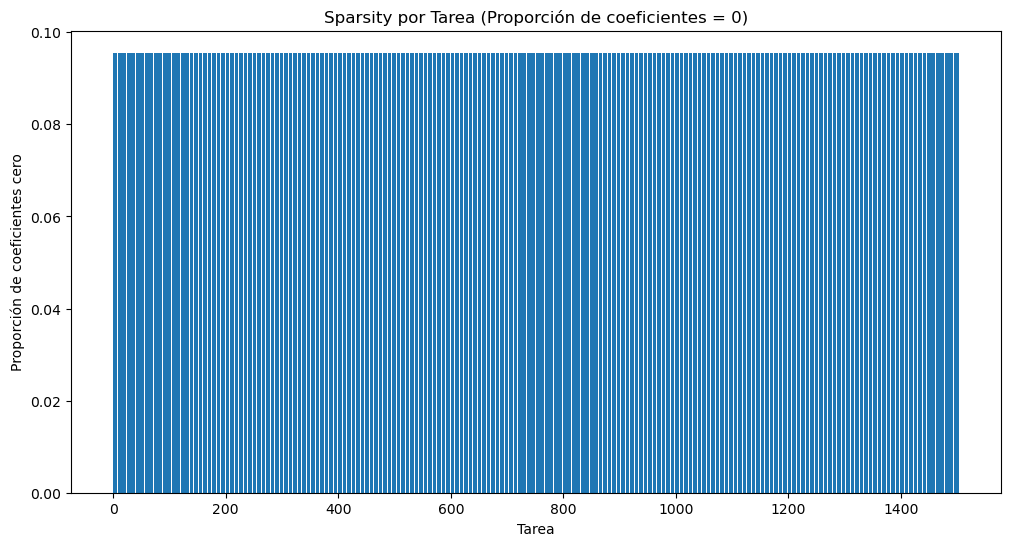

In [61]:
# Identificar features consistentemente seleccionados (no cero)
coef_nonzero = np.any(mejores_rutas != 0, axis=(0, 1))  # Features no cero en algún modelo/tarea
coef_consistent = np.all(np.any(mejores_rutas != 0, axis=0), axis=0)  # Features no cero en todas las tareas

print(f"Features no cero en al menos un modelo/tarea: {np.sum(coef_nonzero)}/{n_features}")
print(f"Features consistentemente no cero en todas las tareas: {np.sum(coef_consistent)}/{n_features}")

# Distribución de sparsity por tarea
sparsity_por_tarea = np.mean(coef_mean == 0, axis=1)
plt.figure(figsize=(12, 6))
plt.bar(range(len(sparsity_por_tarea)), sparsity_por_tarea)
plt.title('Sparsity por Tarea (Proporción de coeficientes = 0)')
plt.xlabel('Tarea')
plt.ylabel('Proporción de coeficientes cero')
plt.show()

In [57]:
# Analizar características importantes por tarea
n_tareas = mejores_rutas.shape[1]
n_features = mejores_rutas.shape[2]

# Coeficientes promedio absolutos por feature (importancia general)
coef_abs_mean = np.mean(np.abs(coef_mean), axis=0)

# Top features más importantes globalmente
top_n = 20
top_features_idx = np.argsort(coef_abs_mean)[-top_n:][::-1]

print(f"Top {top_n} features más importantes globalmente:")
for i, idx in enumerate(top_features_idx):
    print(f"{i+1}. Feature {idx}: {coef_abs_mean[idx]:.4f}")

Top 20 features más importantes globalmente:
1. Feature 1648: 0.0051
2. Feature 2944: 0.0043
3. Feature 2709: 0.0042
4. Feature 1584: 0.0042
5. Feature 3085: 0.0041
6. Feature 3169: 0.0041
7. Feature 2770: 0.0040
8. Feature 2249: 0.0040
9. Feature 3063: 0.0039
10. Feature 1864: 0.0039
11. Feature 2765: 0.0039
12. Feature 1080: 0.0039
13. Feature 229: 0.0039
14. Feature 1598: 0.0038
15. Feature 3241: 0.0037
16. Feature 3019: 0.0037
17. Feature 2763: 0.0037
18. Feature 340: 0.0037
19. Feature 2284: 0.0037
20. Feature 3038: 0.0036
